# NeurIPS2018_SB3

This is a modification version based on the first notebook from [FinRL-tutorial](https://github.com/AI4Finance-Foundation/FinRL-Tutorials)

https://github.com/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb

## Part 1. Task Discription
DRL agent training for cryptocurrency trading. 

This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The states of the OHLCVT trading information consists of two co-moving assets (BTCUSD and BTCEUR).

* **Action a**: The action space includes buying and selling. However, a certain limitation is included to operate on both assets. The pair shall never be actioned alone, it must come with a reversed direction.

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s', i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively

**Market environment**: Cryptocurrencies from Binance

##  Part 2. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime, sqlite3, zipfile, os

%matplotlib inline
# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from T2.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/Users/HSY/miniconda3/envs/uoa-mdt/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


### Create Folders

In [2]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

### Read Data

Read data from `binance-public-data`

In [3]:
TRAIN_START_DATE = '2017-08-17'
TRAIN_END_DATE = '2022-12-31'
TRADE_START_DATE = '2023-01-01'
TRADE_END_DATE = '2023-07-31'

In [4]:
# List of symbols to merge
symbols = ['BTCUSDT', 'ETHUSDT']

# List to store individual DataFrames
rawdfs = []

# Loop through each symbol
for symbol in symbols:
    directory = f'../mdt_utils/binance-public-data/python/data/spot/monthly/klines/{symbol}/1d/'
    
    # Loop through each zip file in the directory
    for file_name in os.listdir(directory):
        if file_name.endswith('.zip'):
            with zipfile.ZipFile(os.path.join(directory, file_name), 'r') as zip_ref:
                # only one CSV file in each zip archive
                csv_file = zip_ref.namelist()[0]
                with zip_ref.open(csv_file) as csv_fp:
                    # Read the CSV data into a DataFrame
                    temp_df = pd.read_csv(csv_fp, header=None)
                    temp_df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
                    temp_df['date'] = pd.to_datetime(temp_df['close_time'], unit='ms').dt.strftime('%Y-%m-%d')
                    temp_df['day'] = (pd.to_datetime(temp_df['date']) - pd.to_datetime(temp_df['date'].iloc[0])).dt.days
                    temp_df['tic'] = symbol
                    rawdfs.append(temp_df[['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day']])

# Concatenate all DataFrames into a single DataFrame
rawdf = pd.concat(rawdfs, ignore_index=True)

# Count the number of unique 'tic' values per date
tic_counts = rawdf.groupby('date')['tic'].nunique()

# Filter the DataFrame to keep only rows where all 'tic' values participate
df = rawdf[rawdf['date'].isin(tic_counts[tic_counts == len(rawdf['tic'].unique())].index)]

df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,BTCUSDT,0
1,2017-08-17,301.13,312.18,298.00,302.00,7030.710340,ETHUSDT,0
2,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,BTCUSDT,1
3,2017-08-18,302.00,311.79,283.94,293.96,9537.846460,ETHUSDT,1
4,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,BTCUSDT,2


## Part 4. Preprocess Data

TODO: The default feature engineering is based on date. I need to rewrite into timestamp based method

The dafult [data split](https://github.com/AI4Finance-Foundation/FinRL/blob/master/finrl/meta/preprocessor/preprocessors.py) is not applicable here. Need to manually redo it.

In [5]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1496, 8)
Successfully added vix


In [6]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [7]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2017-08-17,BTCUSDT,4261.48,4485.39,4200.74,4285.08,795.150377,0.0,0.000000,4446.630679,3946.819321,0.000000,-66.666667,100.000000,4285.080,4285.080,15.55
1,2017-08-17,ETHUSDT,301.13,312.18,298.00,302.00,7030.710340,0.0,0.000000,4446.630679,3946.819321,0.000000,-66.666667,100.000000,302.000,302.000,15.55
2,2017-08-18,BTCUSDT,4285.08,4371.52,3938.77,4108.37,1199.888264,1.0,-3.964647,4446.630679,3946.819321,0.000000,-66.666667,100.000000,4196.725,4196.725,14.26
3,2017-08-18,ETHUSDT,302.00,311.79,283.94,293.96,9537.846460,1.0,-0.180385,309.350277,286.609723,0.000000,-66.666667,100.000000,297.980,297.980,14.26
4,2017-08-21,BTCUSDT,4069.13,4119.62,3911.79,4016.00,691.743060,4.0,-9.655882,4325.847407,3928.440593,9.487016,-92.693236,88.718699,4127.144,4127.144,13.19


## Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing cryptocurrency price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

### Data Split
We split the data into training set and testing set as follows:

In [8]:
train = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE, TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(f"Training Data length: {train_length}")
print(f"Trade Data Length: {trade_length}")
print(f"Indicators: {INDICATORS}")

Training Data length: 2706
Trade Data Length: 286
Indicators: ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']


Because we are trading with 2 assets as a pair, therefore we have only 1 pair_dimension

> `1`: Represents the cash balance. There's one element in the state for the agent's cash.
>
> `2 * stock_dimension`: Represents the stock prices and stock ownership. There are two elements for each stock: one for the stock price and one for the number of shares owned.
>
> `len(INDICATORS) * stock_dimension`: Represents the technical indicators for each stock. Each indicator contributes one element per stock.

In [9]:
stock_dimension = len(train.tic.unique())

state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"stock Dimension: {stock_dimension}, State Space: {state_space}")

stock Dimension: 2, State Space: 21


In [10]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

if stock_dimension != 2:
    raise ValueError("Stock dimension must be equal to 2 for pair trading.")

env_kwargs = {
    "hmax": 10, # int, maximum number of USDT to trade
    "initial_amount": 100000, # start with 1000000 USDT
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list, # transaction cost percentage per trade
    "sell_cost_pct": sell_cost_list, # transaction cost percentage per trade
    "state_space": state_space,
    "stock_dim": 2, # we will always have 2 stocks
    "tech_indicator_list": INDICATORS,
    "action_space": 2, # we only allow the trade to give a single action
    "reward_scaling": 1e-4 # scaling factor for reward, good for training
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [11]:
# An example of state
# 94502.19235000112: This is the available cash balance that the agent has for making trading decisions.
# 24948.21: The price of the first stock in your trading pair (e.g., BTC-GBP).
# 21668.05: The price of the second stock in your trading pair (e.g., BTC-EUR).
# 103: The number of shares the agent holds for the first stock (e.g., BTC-GBP).
# 0: The number of shares the agent holds for the second stock (e.g., BTC-EUR).
# -299.9631790789099: A technical indicator value.
# -345.112034646816: A technical indicator value.
# 26817.756609157783: A technical indicator value.
# 23644.528099789444: A technical indicator value.
# 24186.333390842214: A technical indicator value.
# 20930.97290021056: A technical indicator value.
# 48.63796032144048: A technical indicator value.
# 47.40677058214158: A technical indicator value.
# -74.29641721884254: A technical indicator value.
# -89.66529346827706: A technical indicator value.
# 12.572876815282788: A technical indicator value.
# 16.60796108870377: A technical indicator value.
# 25597.621333333333: A technical indicator value.
# 22452.637666666666: A technical indicator value.
# 25993.954166666666: A technical indicator value.
# 22842.914500000003: A technical indicator value.

e_train_gym.state

[100000,
 4285.08,
 302.0,
 0,
 0,
 0.0,
 0.0,
 4446.630678606951,
 4446.630678606951,
 3946.81932139305,
 3946.81932139305,
 0.0,
 0.0,
 -66.666666666667,
 -66.666666666667,
 100.0,
 100.0,
 4285.08,
 302.0,
 4285.08,
 302.0]

### Environment for Training

In [12]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [38]:
train

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2017-08-17,BTCUSDT,4261.48,4485.39,4200.74,4285.08,795.150377,0.0,0.000000,4446.630679,3946.819321,0.000000,-66.666667,100.000000,4285.080000,4285.080000,15.550000
0,2017-08-17,ETHUSDT,301.13,312.18,298.00,302.00,7030.710340,0.0,0.000000,4446.630679,3946.819321,0.000000,-66.666667,100.000000,302.000000,302.000000,15.550000
1,2017-08-18,BTCUSDT,4285.08,4371.52,3938.77,4108.37,1199.888264,1.0,-3.964647,4446.630679,3946.819321,0.000000,-66.666667,100.000000,4196.725000,4196.725000,14.260000
1,2017-08-18,ETHUSDT,302.00,311.79,283.94,293.96,9537.846460,1.0,-0.180385,309.350277,286.609723,0.000000,-66.666667,100.000000,297.980000,297.980000,14.260000
2,2017-08-21,BTCUSDT,4069.13,4119.62,3911.79,4016.00,691.743060,4.0,-9.655882,4325.847407,3928.440593,9.487016,-92.693236,88.718699,4127.144000,4127.144000,13.190000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,2022-12-28,ETHUSDT,1211.55,1215.78,1181.06,1190.15,367828.891400,27.0,-13.556833,1317.115002,1143.339998,45.345868,-87.159035,31.922068,1241.650333,1280.678833,22.139999
1351,2022-12-29,BTCUSDT,16547.32,16664.41,16488.91,16633.47,160998.471580,28.0,-125.739003,17667.869492,16205.851508,44.562902,-116.527071,20.622563,16973.549000,17343.340833,21.440001
1351,2022-12-29,ETHUSDT,1190.15,1206.57,1186.77,1200.49,249130.486900,28.0,-13.782247,1313.507949,1140.686051,46.000465,-82.365815,31.922068,1241.117000,1274.179667,21.440001
1352,2022-12-30,BTCUSDT,16633.47,16677.35,16333.00,16607.48,164916.311740,29.0,-130.253397,17650.263541,16171.456459,44.405086,-122.471176,25.159441,16955.010333,17278.619833,21.670000


## Part 6. Train DRL Agents
* The DRL algorithms are from Stable Baselines 3. Users are also encouraged to try ElegantRL and Ray RLlib.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

design their own DRL algorithms by adapting these DRL algorithms.

In [13]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

### Agent 1: A2C

In [14]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [15]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

-------------------------------------
| time/                 |           |
|    fps                | 1016      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -2.8      |
|    explained_variance | -0.19     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -6.28     |
|    reward             | 1.3217335 |
|    std                | 0.979     |
|    value_loss         | 6.36      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 1075       |
|    iterations         | 200        |
|    time_elapsed       | 0          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -2.83      |
|    explained_variance | 0.134      |
|    learning_rate      | 0.0007     |
| 

In [16]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [17]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [18]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 1352, episode: 40
begin_total_asset: 100000.00
end_total_asset: -317930161.52
total_reward: -318030161.52
total_cost: -526138.80
total_trades: 5408
Sharpe: 0.450
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 297       |
|    time_elapsed    | 18        |
|    total_timesteps | 5412      |
| train/             |           |
|    actor_loss      | -3.72e+05 |
|    critic_loss     | 3.29e+10  |
|    learning_rate   | 0.001     |
|    n_updates       | 4059      |
|    reward          | 35.22919  |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 258       |
|    time_elapsed    | 41        |
|    total_timesteps | 10824     |
| train/             |           |
|    actor_loss      | -2.99e+05 |
|    critic_loss     | 1.94e+09  |
|    learning_rate   | 0.001     |
|    n_updates       | 9471 

In [19]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [20]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [21]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 1754       |
|    iterations      | 1          |
|    time_elapsed    | 1          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.06866107 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1679        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005470558 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.0304     |
|    learning_rate        | 0.00025     |
|    loss                 | 15.3        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00459    |
|   

In [22]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

### Agent 4: TD3

In [23]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [24]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 320        |
|    time_elapsed    | 16         |
|    total_timesteps | 5412       |
| train/             |            |
|    actor_loss      | -1.19e+03  |
|    critic_loss     | 5.4e+05    |
|    learning_rate   | 0.001      |
|    n_updates       | 4059       |
|    reward          | 0.09252388 |
-----------------------------------
day: 1352, episode: 120
begin_total_asset: 100000.00
end_total_asset: 1029010.74
total_reward: 929010.74
total_cost: -1052234.74
total_trades: 5408
Sharpe: -0.524
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 283        |
|    time_elapsed    | 38         |
|    total_timesteps | 10824      |
| train/             |            |
|    actor_loss      | -831       |
|    critic_loss     | 3.3e+04    |
|    learning_rate   | 0.001      |
|    n_up

In [25]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

### Agent 5: SAC

### In-sample Performance
Assume that the initial capital is $1,000,000.

### Trading (Out-of-sample Performance)
We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

The Env
https://github.com/AI4Finance-Foundation/FinRL/blob/master/finrl/meta/env_stock_trading/env_stocktrading.py

In [26]:
# env_kwargs = {
#     "hmax": 1, # int, maximum number of bitcoins to trade
#     "initial_amount": 1000000, # start money
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list, # transaction cost percentage per trade
#     "sell_cost_pct": sell_cost_list, # transaction cost percentage per trade
#     "state_space": state_space,
#     "stock_dim": 2, # we will always have 2 stocks
#     "tech_indicator_list": INDICATORS,
#     "action_space": 1, # we only allow the trade to give a single action
#     "reward_scaling": 1e-4 # scaling factor for reward, good for training
# }

e_trade_gym = StockTradingEnv(df = trade, risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [27]:
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

trained_a2c = A2C.load("trained_models/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load("trained_models/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load("trained_models/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load("trained_models/agent_td3") if if_using_td3 else None
trained_sac = SAC.load("trained_models/agent_sac") if if_using_sac else None

In [28]:
trained_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


In [29]:
trained_model = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


In [30]:
trained_model = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


In [31]:
trained_model = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


## Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [34]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
# df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
# df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_td3.rename(columns = {'account_value':'td3'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
# df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
# df_result_sac.rename(columns = {'account_value':'sac'}, inplace = True)

result = pd.DataFrame()
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
# result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
# result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
print(result.head())
# result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']

# print("result: ", result)
result.to_csv(RESULTS_DIR + "/result.csv")

                    a2c          td3            ppo
date                                               
2023-01-03  100000.0000  100000.0000  100000.000000
2023-01-04   98748.4554   98748.4554  100492.235733
2023-01-05   99607.5698   99607.5698  100444.112096
2023-01-06   99092.8438   99092.8438  100761.098403
2023-01-09   97494.7698   97494.7698  101307.451430


<Figure size 1500x500 with 0 Axes>

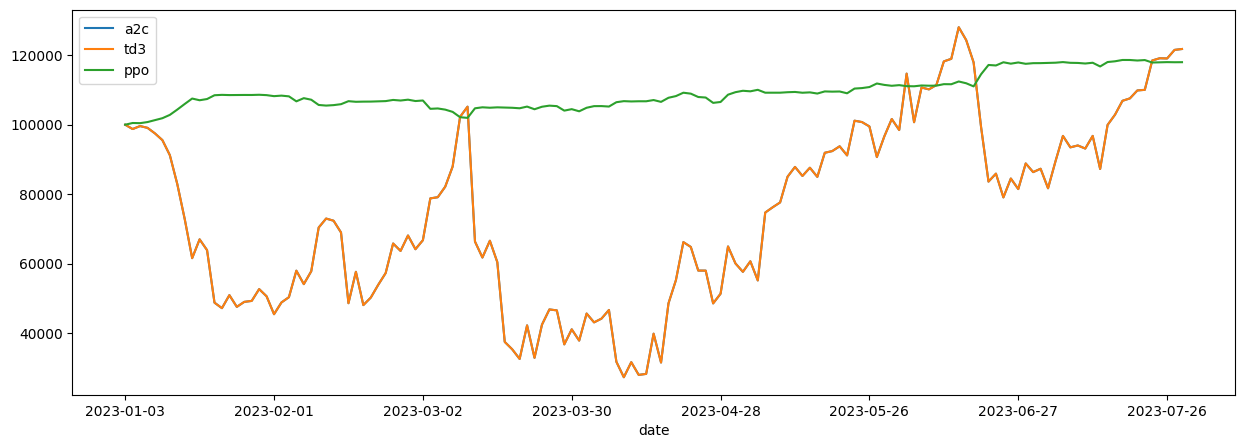

In [35]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();